In [9]:
# === Celda 1: Imports, rutas, device y parámetros ===
from pathlib import Path
import time, random
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.utils.data import WeightedRandomSampler
import numpy as np

# ---- Rutas (ajústalas si hace falta) ----
DATA_DIR = Path(r"D:/proyectos/Caso_aprendizaje-Melanomas/data/raw")
TRAIN_DIR = DATA_DIR / "train"
VAL_DIR   = DATA_DIR / "val"
TEST_DIR  = DATA_DIR / "test"

for p in (TRAIN_DIR, VAL_DIR, TEST_DIR):
    print(p, "exists:", p.exists())

# ---- Semillas fijas ----
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

# Desactivar optimizaciones específicas de GPU
torch.backends.cudnn.deterministic = False
torch.backends.cudnn.benchmark = False

# ---- Device (solo CPU) ----
device = torch.device("cpu")
print("Device for training:", device)

# ---- Parámetros de datos/entreno ----
CLASSES = 2
ROWS = COLS = 224
BATCH = 16
EPOCHS = 15
LR = 1e-3
NUM_WORKERS = 0            # En Windows, 0 es lo más estable.
USE_AMP = False            # Desactivado porque Mixed Precision solo sirve en GPU.

# ---- Normalización (ImageNet) ----
IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD  = (0.229, 0.224, 0.225)


D:\proyectos\Caso_aprendizaje-Melanomas\data\raw\train exists: True
D:\proyectos\Caso_aprendizaje-Melanomas\data\raw\val exists: True
D:\proyectos\Caso_aprendizaje-Melanomas\data\raw\test exists: True
Device for training: cpu


In [10]:
# === Celda 2: Transforms (tratado de imagen) + DataLoaders ===
train_tfms = transforms.Compose([
    transforms.Resize((ROWS, COLS)),

    # --- Augmentaciones ligeras ---
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15, fill=tuple(int(m*255) for m in IMAGENET_MEAN)),  # evita bordes negros

    # --- Luz/contraste ---
    transforms.ColorJitter(brightness=0.15, contrast=0.15),   # ±15%
    transforms.RandomAutocontrast(p=0.3),

    # --- Bordes/nitidez (suave) ---
    transforms.RandomAdjustSharpness(sharpness_factor=1.5, p=0.3),
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 0.8)),  # opcional, suaviza ruido fino

    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

val_tfms = transforms.Compose([
    transforms.Resize((ROWS, COLS)),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

# Datasets
train_ds = datasets.ImageFolder(TRAIN_DIR, transform=train_tfms)
val_ds   = datasets.ImageFolder(VAL_DIR,   transform=val_tfms)
print("Clases:", train_ds.classes)
assert len(train_ds.classes) == CLASSES, f"Esperaba {CLASSES} clases."

# DataLoaders

targets = np.array([y for _, y in train_ds.samples])
class_counts = np.bincount(targets, minlength=CLASSES)
class_weights = 1.0 / (class_counts + 1e-6)
sample_weights = class_weights[targets]

sampler = WeightedRandomSampler(weights=sample_weights,
                                num_samples=len(sample_weights),
                                replacement=True)

train_dl = DataLoader(train_ds, batch_size=BATCH, sampler=sampler,
                      num_workers=NUM_WORKERS, pin_memory=True)

val_dl = DataLoader(val_ds, batch_size=BATCH, shuffle=False,
                    num_workers=NUM_WORKERS, pin_memory=True)

print("Class counts:", class_counts, "-> weights:", class_weights)



Clases: ['Benign', 'Malignant']
Class counts: [5346 4752] -> weights: [0.00018706 0.00021044]


In [11]:
# === Celda 3: Definición del modelo CNN ===
class SmallCNN(nn.Module):
    def __init__(self, in_ch=3, num_classes=2, drop_conv=0.20, drop_fc=0.5):
        super().__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(in_ch, 32, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(32), nn.ReLU(inplace=True),
            nn.MaxPool2d(2,2), nn.Dropout(drop_conv),
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64), nn.ReLU(inplace=True),
            nn.MaxPool2d(2,2), nn.Dropout(drop_conv),
        )
        self.block3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(128), nn.ReLU(inplace=True),
            nn.MaxPool2d(2,2), nn.Dropout(drop_conv),
        )
        self.block4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(256), nn.ReLU(inplace=True),
            nn.MaxPool2d(2,2), nn.Dropout(drop_conv),
        )
        self.gap = nn.AdaptiveAvgPool2d((1,1))
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(drop_fc),
            nn.Linear(256, num_classes),
        )

    def forward(self, x):
        x = self.block1(x)   # 224 -> 112
        x = self.block2(x)   # 112 -> 56
        x = self.block3(x)   # 56  -> 28
        x = self.block4(x)   # 28  -> 14
        x = self.gap(x)      # -> [B,256,1,1]
        x = self.classifier(x)  # -> [B,2]
        return x

model = SmallCNN(in_ch=3, num_classes=CLASSES).to(device)
params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Parámetros entrenables: {params:,}")


Parámetros entrenables: 389,410


In [12]:
# === Celda 4: Loss, optimizador y métrica ===
import torch.nn as nn
w = torch.tensor(class_weights, dtype=torch.float32, device=device)
criterion = nn.CrossEntropyLoss(weight=w, label_smoothing=0.05)

optimizer = torch.optim.Adam(model.parameters(), lr=LR)

def accuracy_from_logits(logits, targets):
    preds = logits.argmax(dim=1)
    return (preds == targets).float().mean().item()


In [13]:
# === Celda 5: Entreno/validación ===
scaler = torch.amp.GradScaler(enabled=USE_AMP and device.type == "cuda")

def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss, total_acc, n = 0.0, 0.0, 0
    for x, y in loader:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)
        with torch.amp.autocast(device_type="cuda", dtype=torch.float16,
                                enabled=USE_AMP and device.type == "cuda"):
            logits = model(x)
            loss = criterion(logits, y)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()
        total_acc  += accuracy_from_logits(logits, y)
        n += 1
    return total_loss / max(n,1), total_acc / max(n,1)

@torch.no_grad()
def validate(model, loader, criterion):
    model.eval()
    total_loss, total_acc, n = 0.0, 0.0, 0
    for x, y in loader:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)
        logits = model(x)
        loss = criterion(logits, y)
        total_loss += loss.item()
        total_acc  += accuracy_from_logits(logits, y)
        n += 1
    return total_loss / max(n,1), total_acc / max(n,1)

history = {"train_loss":[], "train_acc":[], "val_loss":[], "val_acc":[]}
BEST_PATH = "smallcnn_simple_best.pth"

# === Scheduler + Early Stopping ===
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=3, verbose=True
)

EARLY_PATIENCE = 6
no_improve = 0
best_val = float('inf')   # <- solo aquí

for epoch in range(1, EPOCHS+1):
    t0 = time.time()
    tr_loss, tr_acc = train_one_epoch(model, train_dl, optimizer, criterion)
    va_loss, va_acc = validate(model, val_dl, criterion)

    # guarda historial para las curvas
    history["train_loss"].append(tr_loss); history["train_acc"].append(tr_acc)
    history["val_loss"].append(va_loss);   history["val_acc"].append(va_acc)

    scheduler.step(va_loss)

    # guarda mejor checkpoint por val_loss
    if va_loss < best_val:
        best_val = va_loss
        torch.save({"model": model.state_dict(),
                    "classes": train_ds.classes}, BEST_PATH)
        no_improve = 0
    else:
        no_improve += 1
        if no_improve >= EARLY_PATIENCE:
            print("Early stopping 🚦")
            break

    # (opcional) muestra LR actual
    cur_lr = optimizer.param_groups[0]["lr"]
    dt = time.time() - t0
    print(f"[{epoch:02d}] train_loss={tr_loss:.4f} acc={tr_acc:.4f} | "
          f"val_loss={va_loss:.4f} acc={va_acc:.4f} | lr={cur_lr:.2e} | {dt:.1f}s")

    # (opcional) aligerar memoria entre épocas
    if device.type == "cuda":
        torch.cuda.empty_cache()


d:\proyectos\Caso_aprendizaje-Melanomas\.venv\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[01] train_loss=0.5601 acc=0.7254 | val_loss=0.5030 acc=0.7548 | lr=1.00e-03 | 1186.6s
[02] train_loss=0.5452 acc=0.7418 | val_loss=0.4877 acc=0.7728 | lr=1.00e-03 | 995.6s
[03] train_loss=0.4967 acc=0.7793 | val_loss=0.4872 acc=0.7804 | lr=1.00e-03 | 869.1s
[04] train_loss=0.4596 acc=0.8043 | val_loss=0.4540 acc=0.8031 | lr=1.00e-03 | 821.4s
[05] train_loss=0.4364 acc=0.8244 | val_loss=0.4620 acc=0.8003 | lr=1.00e-03 | 807.6s
[06] train_loss=0.4301 acc=0.8265 | val_loss=0.4070 acc=0.8358 | lr=1.00e-03 | 796.8s
[07] train_loss=0.4119 acc=0.8350 | val_loss=0.3998 acc=0.8430 | lr=1.00e-03 | 812.7s
[08] train_loss=0.4123 acc=0.8364 | val_loss=0.3893 acc=0.8396 | lr=1.00e-03 | 806.7s
[09] train_loss=0.4018 acc=0.8425 | val_loss=0.4529 acc=0.8026 | lr=1.00e-03 | 808.1s
[10] train_loss=0.3987 acc=0.8474 | val_loss=0.4323 acc=0.8330 | lr=1.00e-03 | 803.0s
[11] train_loss=0.3908 acc=0.8511 | val_loss=0.3819 acc=0.8503 | lr=1.00e-03 | 802.0s
[12] train_loss=0.3893 acc=0.8493 | val_loss=0.3985 a

In [14]:
# === Celda 6: Evaluación en test ===
from collections import Counter

# Cargar mejor modelo
ckpt = torch.load(BEST_PATH, map_location=device)
model.load_state_dict(ckpt["model"])
model.eval()

test_ds = datasets.ImageFolder(TEST_DIR, transform=val_tfms)
test_dl = DataLoader(test_ds, batch_size=BATCH, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

@torch.no_grad()
def evaluate_loader(model, loader):
    model.eval()
    total, correct = 0, 0
    per_class = Counter()
    per_class_correct = Counter()

    for x, y in loader:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)
        logits = model(x)
        preds = logits.argmax(dim=1)
        correct += (preds == y).sum().item()
        total   += y.numel()

        for yi, pi in zip(y.tolist(), preds.tolist()):
            per_class[yi] += 1
            if yi == pi:
                per_class_correct[yi] += 1

    acc = correct / total if total else 0.0
    return acc, per_class, per_class_correct

test_acc, counts, rights = evaluate_loader(model, test_dl)
print(f"Test accuracy: {test_acc:.4f}")
idx2class = {i:c for i,c in enumerate(test_ds.classes)}
for i in range(len(test_ds.classes)):
    n = counts[i]
    ok = rights[i]
    name = idx2class[i]
    if n > 0:
        print(f"  {name:>10s}: {ok}/{n} ({ok/n:.3f})")
    else:
        print(f"  {name:>10s}: 0/0 (N/A)")


C:\Users\lucia\AppData\Local\Temp\ipykernel_19104\142757775.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(BEST_PATH, map_location=device)


Test accuracy: 0.8500
      Benign: 917/1000 (0.917)
   Malignant: 783/1000 (0.783)


In [15]:
# === Celda nueva: Umbral óptimo (maximiza F1) ===
import numpy as np
from sklearn.metrics import f1_score, recall_score

def collect_probs_labels(model, loader, malignant_idx=1):
    model.eval()
    probs, labels = [], []
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            logits = model(x)
            p = torch.softmax(logits, dim=1)[:, malignant_idx].cpu().numpy()
            probs.append(p); labels.append(y.numpy())
    return np.concatenate(probs), np.concatenate(labels)

val_probs, val_y = collect_probs_labels(model, val_dl, malignant_idx=1)

best_f1, best_t = -1, 0.5
for t in np.linspace(0.1, 0.9, 33):
    preds = (val_probs >= t).astype(int)
    f1 = f1_score(val_y, preds, pos_label=1)
    if f1 > best_f1:
        best_f1, best_t = f1, t

print(f"Umbral óptimo (F1) para Malignant: {best_t:.2f}, F1={best_f1:.3f}")
OPT_THRESH = best_t


Umbral óptimo (F1) para Malignant: 0.38, F1=0.843


In [16]:
# === Evaluación final con umbral óptimo ===
from sklearn.metrics import classification_report, confusion_matrix

test_probs, test_y = collect_probs_labels(model, test_dl, malignant_idx=1)
test_pred = (test_probs >= OPT_THRESH).astype(int)

print("\n📋 Reporte con umbral óptimo:")
print(classification_report(test_y, test_pred, target_names=test_ds.classes))
print("Matriz de confusión (umbral ajustado):\n", confusion_matrix(test_y, test_pred))


📋 Reporte con umbral óptimo:
              precision    recall  f1-score   support

      Benign       0.90      0.85      0.88      1000
   Malignant       0.86      0.91      0.88      1000

    accuracy                           0.88      2000
   macro avg       0.88      0.88      0.88      2000
weighted avg       0.88      0.88      0.88      2000

Matriz de confusión (umbral ajustado):
 [[849 151]
 [ 90 910]]


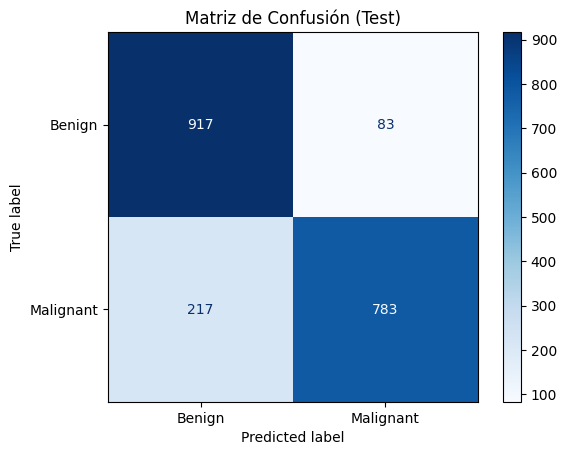


📊 Reporte de clasificación:
              precision    recall  f1-score   support

      Benign       0.81      0.92      0.86      1000
   Malignant       0.90      0.78      0.84      1000

    accuracy                           0.85      2000
   macro avg       0.86      0.85      0.85      2000
weighted avg       0.86      0.85      0.85      2000



In [17]:
# === Celda 7: Matriz de confusión y métricas ===
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# --- Paso 1: recopilar predicciones y etiquetas reales ---
all_preds, all_labels = [], []

model.eval()
with torch.no_grad():
    for x, y in test_dl:
        x = x.to(device, non_blocking=True)
        logits = model(x)
        preds = logits.argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(y.numpy())

# --- Paso 2: matriz de confusión ---
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=test_ds.classes)
disp.plot(cmap="Blues", values_format='d')
plt.title("Matriz de Confusión (Test)")
plt.show()

# --- Paso 3: métricas detalladas ---
print("\n📊 Reporte de clasificación:")
print(classification_report(all_labels, all_preds, target_names=test_ds.classes))


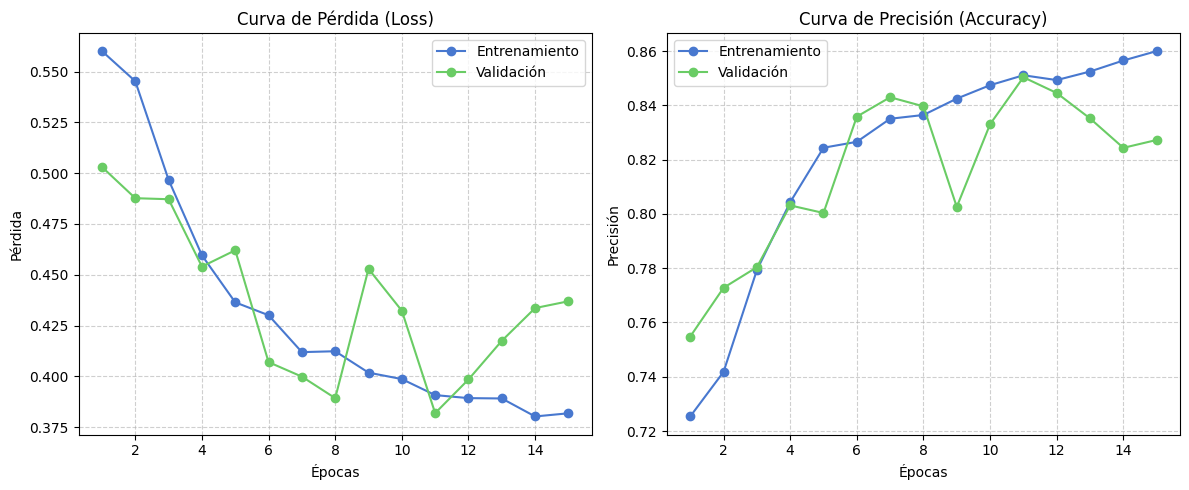

In [18]:
# === Celda 8: Curvas de pérdida y precisión ===
import matplotlib.pyplot as plt

# --- Configuración del estilo ---
plt.style.use('seaborn-v0_8-muted')

epochs_range = range(1, len(history["train_loss"]) + 1)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# --- Curva de pérdida ---
ax[0].plot(epochs_range, history["train_loss"], label='Entrenamiento', marker='o')
ax[0].plot(epochs_range, history["val_loss"], label='Validación', marker='o')
ax[0].set_title("Curva de Pérdida (Loss)")
ax[0].set_xlabel("Épocas")
ax[0].set_ylabel("Pérdida")
ax[0].legend()
ax[0].grid(True, linestyle='--', alpha=0.6)

# --- Curva de precisión ---
ax[1].plot(epochs_range, history["train_acc"], label='Entrenamiento', marker='o')
ax[1].plot(epochs_range, history["val_acc"], label='Validación', marker='o')
ax[1].set_title("Curva de Precisión (Accuracy)")
ax[1].set_xlabel("Épocas")
ax[1].set_ylabel("Precisión")
ax[1].legend()
ax[1].grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()
